In [1]:
%run ./config.ipynb
%run ./Architecture.ipynb

8


In [2]:
import matplotlib as plt
from keras.applications.vgg16 import VGG16
from keras.layers.convolutional import UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory as image_data_dir
import keras
import keras.backend
from keras.layers import Input
import tensorflow as tf
from skimage import data, io
import skimage.transform
from skimage.transform import rescale, resize
from scipy.ndimage import rotate
import numpy as np
from numpy import array, asarray
import os, random
from natsort import natsorted, ns

In [3]:
# Allows reproducibility of results
np.random.seed(7)
print(config.TRAIN)
image_shape = (config.TRAIN.image_shape)
print(image_shape)

{'batch_size': 8, 'epochs': 20, 'hr_images': '../BSR/BSDS500/data/images', 'training_img': '../BSR/BSDS500/data/images/train', 'testing_img': '../BSR/BSDS500/data/images/test', 'validation': '../BSR/BSDS500/data/images/val', 'downscale': 4, 'image_shape': [256, 256, 3], 'lr_init': 0.001, 'filters': 64, 'kernel': [3, 3], 'stride': 1}
[256, 256, 3]


In [4]:
def vgg_loss(true_image, predicted_image):
    vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=image_shape)
    vgg19.trainable = False
    for l in vgg19.layers:
        l.trainable = False
    loss_model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
    loss_model.trainable = False
    return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))

In [5]:
def make_gan(d, image_shape, g, optimizer):
    d.trainable = False
    gan_input = Input(shape=image_shape)
    network = g(gan_input)
    gan_output = discriminator(network)
    gan = Model(inputs=gan_input, outputs=[network,gan_output])
    gan.compile(loss=[vgg_loss, "binary_crossentropy"],
                loss_weights=[1., config.TRAIN.lr_init],
                optimizer=optimizer)

    return gan

In [86]:
#bring the values in range [-1.0,1.0]
def normal(image):
    image = (image/127.5)-1
    return image

def denormal(image):
    image = (image+1) * 127.5
    return image

Getting dataset from local files

In [7]:
dir_path = os.path.dirname(os.path.abspath("C:/Users/ajwil/Documents/Bsc Dissertation/FinalProject"))
print(dir_path)
root_dir = os.path.abspath("C:/Users/ajwil/Documents/Bsc Dissertation/FinalProject/BSR/BSDS500/data")
print(root_dir)

C:\Users\ajwil\Documents\Bsc Dissertation
C:\Users\ajwil\Documents\Bsc Dissertation\FinalProject\BSR\BSDS500\data


In [8]:
image_crop_dimensions = config.TRAIN.image_shape[0]
downscale_factor = config.TRAIN.downscale
downscaled_size = image_crop_dimensions // downscale_factor
batch_size = 5

print(image_crop_dimensions)
print(downscale_factor)
print(downscaled_size)

256
4
64


Found 500 files belonging to 2 classes.
Using 400 files for training.
Found 500 files belonging to 2 classes.
Using 100 files for validation.
<BatchDataset shapes: (None, 256, 256, 3), types: tf.float32>


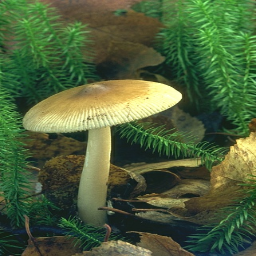

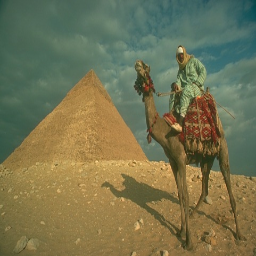

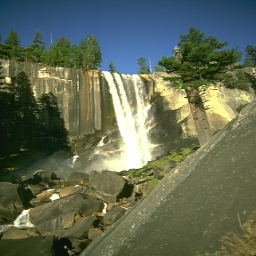

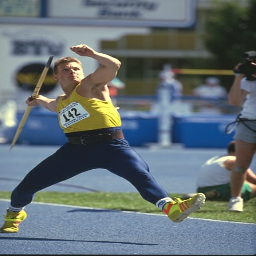

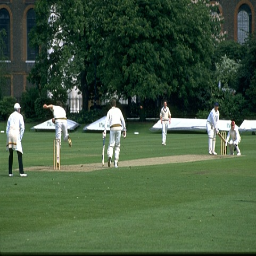

<MapDataset shapes: (None, 256, 256, 3), types: tf.float32>


In [9]:
train_images = image_data_dir(
    root_dir, 
    image_size=(image_crop_dimensions, image_crop_dimensions),
    batch_size=batch_size, 
    validation_split=0.2, 
    seed=7,
    subset='training',
    label_mode=None
)
validation_images = image_data_dir(
    root_dir, 
    image_size=(image_crop_dimensions, image_crop_dimensions),
    batch_size=batch_size, 
    validation_split=0.2, 
    seed=7,
    subset='validation',
    label_mode=None
)
print(train_images)

train_images = train_images.map(normal)
validation_images = validation_images.map(normal)
for batch in train_images.take(1):
    for img in batch:
        display(array_to_img(img))
        
print(train_images)

In [121]:
def load_path(path):
    directory = []
    if os.path.isdir(path):
        print("Directory: ", path, " is a real directory!")
        directory.append(path)
    for elem in os.listdir(path):
        if os.path.isdir(os.path.join(path,elem)):
            directory = directory + load_path(os.path.join(path,elem))
            directory.append(os.path.join(path,elem))
    return directory
    
def load_data_from_folder(folder, ext):
    files = []
    file_names = []
    for img in folder:
        for f in os.listdir(img): 
            if f.endswith(ext):
                image = io.imread(os.path.join(img,f))
                # All images in dataset were either (321,481,3) or (481,321,3) for the purpose of the generator they all had to be same size 
                if (image.shape[0] > image.shape[1]):
                    image = rotate(image, angle=90.0)
                if len(image.shape) > 2:
                    files.append(image)
                    file_names.append(os.path.join(img,f))
                    
    print(" with: ", len(files), " elements!")
    return files

In [43]:
def load_data(directory, ext):

    files = load_data_from_folder(load_path(directory), ext)
    
    rand_check = random.randint(0, len(files)-1)
    print("Random num check of image", rand_check, "has shape: ")
    print(files[rand_check].shape)
    return files

In [116]:
x_train = load_data(config.TRAIN.training_img, '.jpg')
x_test = load_data(config.TRAIN.testing_img, '.jpg')

print("shape of image 1 | ", x_train[0].shape)
print("length of image list | ", len(x_train))

Directory:  ../BSR/BSDS500/data/images/train  is a real directory!
 with:  200  elements!
Random num check of image 49 has shape: 
(321, 481, 3)
Directory:  ../BSR/BSDS500/data/images/test  is a real directory!
 with:  200  elements!
Random num check of image 147 has shape: 
(321, 481, 3)
shape of image 1 |  (321, 481, 3)
length of image list |  200


In [131]:
# Define the high-res images and downsample the low-res images
def low_res(images, downsample_factor):
    img = []
    length = len(images)
    print(length)
    for i in range(length):
        img.append(resize(images[i],
                          [images[i].shape[0]//downsample_factor, 
                                     images[i].shape[1]//downsample_factor]
                         ))
    print("Completed downscaling! With downsample of: ", downsample_factor)
    return array(img)
        
def high_res(images):
    # Added dtype=object to avoid this error
    ## VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. 
    ## If you meant to do this, you must specify 'dtype=object' when creating the ndarray
    img_hr = array(images)
    return img_hr

In [133]:
print(x_train[0].shape[2])
train_hr = high_res(x_train)
train_lr = low_res(x_train, downscale_factor)
print("High res training shape of element 0 for example | ", train_hr[0].shape)
print("Low res training shape of element 0 for example | ", train_lr[0].shape)

3
200
Completed downscaling! With downsample of:  4
High res training shape of element 0 for example |  (321, 481, 3)
Low res training shape of element 0 for example |  (80, 120, 3)


In [134]:
test_hr = high_res(x_test)
test_lr = low_res(x_test, downscale_factor)
print("High res testing shape of element 0 for example | ", train_hr[0].shape)
print("Low res testing shape of element 0 for example | ", train_lr[0].shape)

200
Completed downscaling! With downsample of:  4
High res testing shape of element 0 for example |  (321, 481, 3)
Low res testing shape of element 0 for example |  (80, 120, 3)


Checking downsampling of image |  49


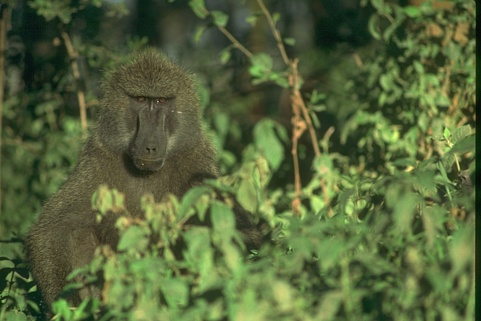

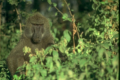

Check if low quality is low quality when upscaled...


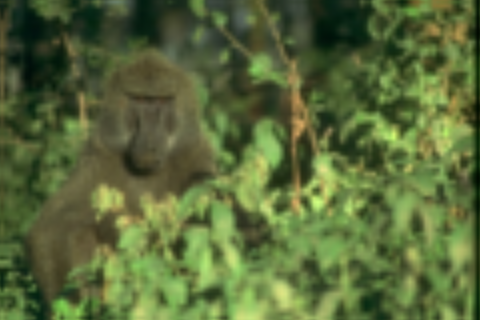

In [141]:
# Check if downsampling works
image_num = random.randint(0, train_hr.shape[0])
print("Checking downsampling of image | ", image_num)

display(array_to_img(train_hr[image_num]))
display(array_to_img(train_lr[image_num]))

lr_upscale = resize(train_lr[image_num],
                           [train_lr[image_num].shape[0]*4,
                            train_lr[image_num].shape[1]*4])
print("Check if low quality is low quality when upscaled...")
display(array_to_img(lr_upscale))

#### Normalization of image arrays!

In [161]:
train_hr = normal(train_hr)
train_lr = normal(train_lr)

test_hr = normal(test_hr)
test_lr = normal(test_lr)

print(train_hr.shape)

(200, 321, 481, 3)


#### Defining the training method where the GAN gets completely trained, to begin with test with 2 epochs

In [8]:
def train(batch_size=config.TRAIN.batch_size):
    downsample = config.TRAIN.downscale
    img_in_batches = int(train_hr.shape[0] / batch_size)
    # Image shapes all have the same dimensions but some are landscape and some are portrait
    lr_img_shape = (train_lr.shape[1], train_lr.shape[2], train_lr.shape[3])
    print(lr_img_shape)

Architecture.GenNet(lr_image_shape)
    
    
train(config.TRAIN.batch_size)

NameError: name 'Architecture' is not defined